<a href="https://colab.research.google.com/github/nupursjsu/Advanced-Deep-Learning/blob/master/Assignment_1_%20Part_2/Semi_Supervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semi Supervised Learning on Breast Cancer dataset

Semi-supervised learning is used when we have large amount of unlabeled data and some labeled data. Labeling data can be time consuming and very expensive. In these scenarios semi-supervised learning is a very benificial approach.

I have used breast cancer dataset from kaggle for demonstrating semi-supervised learning. Following is the link for the dataset

[Breast cancer dataset](https://www.kaggle.com/merishnasuwal/breast-cancer-prediction-dataset)

## Importing necessary libraries

In [87]:
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

import lightgbm as lgb

import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras import regularizers
from keras.losses import mse, binary_crossentropy

## Loading the breast cancer dataset

In [88]:
data = pd.read_csv('Breast_cancer_data.csv')

dataX = data.copy().drop(['diagnosis'],axis=1)
dataY = data['diagnosis'].copy()

#Scaling the data
featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True, with_mean=True, with_std=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])

#Splitting data into train and test set
X_train, X_test, y_train, y_test = \
    train_test_split(dataX, dataY, test_size=0.33, \
                     random_state=2018, stratify=dataY)

In [89]:
#Dropping 95% of the labels from the training set
toDrop = y_train[y_train==1].sample(frac=0.90,random_state=2018)
X_train.drop(labels=toDrop.index,inplace=True)
y_train.drop(labels=toDrop.index,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Defining evaluation function and plotting function

In [90]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF) - \
                   np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

In [91]:
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'], \
                               preds['anomalyScore'])
    average_precision = average_precision_score( \
                        preds['trueLabel'], preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = \
        {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], \
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Area under the \
        curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds, average_precision

## Defining a new function to assess precision at a given recall threshold

In [92]:
def precisionAnalysis(df, column, threshold):
    df.sort_values(by=column, ascending=False, inplace=True)
    threshold_value = threshold*df.trueLabel.sum()
    i = 0
    j = 0
    while i < threshold_value+1:
        if df.iloc[j]["trueLabel"]==1:
            i += 1
        j += 1
    return df, i/j

In [93]:
k_fold = StratifiedKFold(n_splits=5,shuffle=True,random_state=2018)

## Supervised training

In [94]:
params_lightGB = {
    'task': 'train',
    'application':'binary',
    'num_class':1,
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'metric_freq':50,
    'is_training_metric':False,
    'max_depth':4,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': 0,
    'bagging_seed': 2018,
    'verbose': 0,
    'num_threads':16
}

In [95]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[], index=y_train.index, \
                                        columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), \
                                          y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], \
        X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], \
        y_train.iloc[cv_index]
    
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train)
    gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=2000,
                   valid_sets=lgb_eval, early_stopping_rounds=200)
    
    loglossTraining = log_loss(y_train_fold, gbm.predict(X_train_fold, \
                                num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = \
        gbm.predict(X_cv_fold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(y_cv_fold, \
        predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossLightGBMGradientBoosting = log_loss(y_train, \
        predictionsBasedOnKFolds.loc[:,'prediction'])
print('LightGBM Gradient Boosting Log Loss: ', \
        loglossLightGBMGradientBoosting)

[1]	valid_0's binary_logloss: 0.413902
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's binary_logloss: 0.410332
[3]	valid_0's binary_logloss: 0.407397
[4]	valid_0's binary_logloss: 0.404014
[5]	valid_0's binary_logloss: 0.401227
[6]	valid_0's binary_logloss: 0.398013
[7]	valid_0's binary_logloss: 0.395361
[8]	valid_0's binary_logloss: 0.392301
[9]	valid_0's binary_logloss: 0.389314
[10]	valid_0's binary_logloss: 0.38685
[11]	valid_0's binary_logloss: 0.383998
[12]	valid_0's binary_logloss: 0.381644
[13]	valid_0's binary_logloss: 0.378916
[14]	valid_0's binary_logloss: 0.376665
[15]	valid_0's binary_logloss: 0.374052
[16]	valid_0's binary_logloss: 0.371895
[17]	valid_0's binary_logloss: 0.36939
[18]	valid_0's binary_logloss: 0.367321
[19]	valid_0's binary_logloss: 0.364916
[20]	valid_0's binary_logloss: 0.36293
[21]	valid_0's binary_logloss: 0.360618
[22]	valid_0's binary_logloss: 0.358709
[23]	valid_0's binary_logloss: 0.356114
[24]	valid_0's binary_logloss

### Plotting the precision recall and ROC curve

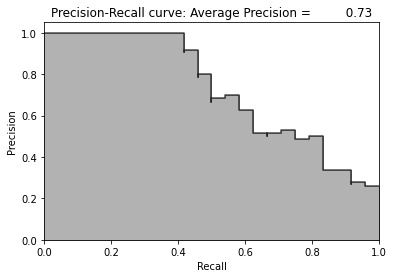

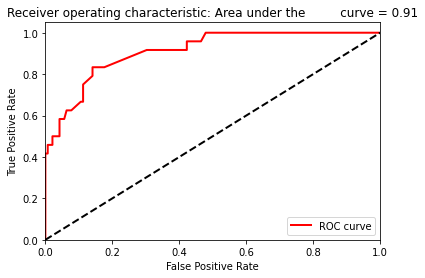

In [96]:
preds, average_precision = plotResults(y_train, \
                        predictionsBasedOnKFolds.loc[:,'prediction'], True)

### Evaluating the model on the test data

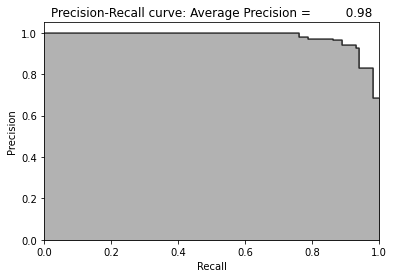

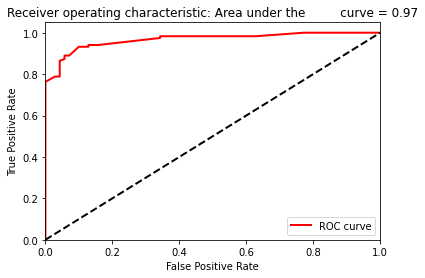

In [97]:
predictions = pd.Series(data=gbm.predict(X_test, \
                num_iteration=gbm.best_iteration), index=X_test.index)
preds, average_precision = plotResults(y_test, predictions, True)

In [98]:
preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print("Precision at 75% recall", precision)

Precision at 75% recall 1.0


## Unsupervised Learning

In [99]:
oversample_multiplier = 100

X_train_original = X_train.copy()
y_train_original = y_train.copy()
X_test_original = X_test.copy()
y_test_original = y_test.copy()

X_train_oversampled = X_train.copy()
y_train_oversampled = y_train.copy()
X_train_oversampled = X_train_oversampled.append( \
        [X_train_oversampled[y_train==1]]*oversample_multiplier, \
        ignore_index=False)
y_train_oversampled = y_train_oversampled.append( \
        [y_train_oversampled[y_train==1]]*oversample_multiplier, \
        ignore_index=False)

X_train = X_train_oversampled.copy()
y_train = y_train_oversampled.copy()

In [106]:
model = Sequential()
model.add(Dense(units=40, activation='linear', \
                activity_regularizer=regularizers.l1(10e-5), \
                input_dim=5,name='hidden_layer'))
model.add(Dropout(0.02))
model.add(Dense(units=5, activation='linear'))

In [107]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [108]:
num_epochs = 5
batch_size = 32

history = model.fit(x=X_train, y=X_train,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.20,
                    verbose=1)

Epoch 1/5
65/65 [==============================] - 0s 5ms/step - loss: 0.3129 - accuracy: 0.6233 - val_loss: 0.0516 - val_accuracy: 0.8346
Epoch 2/5
65/65 [==============================] - 0s 3ms/step - loss: 0.0332 - accuracy: 0.8504 - val_loss: 0.0063 - val_accuracy: 0.9163
Epoch 3/5
65/65 [==============================] - 0s 3ms/step - loss: 0.0139 - accuracy: 0.8582 - val_loss: 0.0030 - val_accuracy: 0.8755
Epoch 4/5
65/65 [==============================] - 0s 3ms/step - loss: 0.0127 - accuracy: 0.8645 - val_loss: 0.0035 - val_accuracy: 0.9163
Epoch 5/5
65/65 [==============================] - 0s 3ms/step - loss: 0.0113 - accuracy: 0.8504 - val_loss: 0.0028 - val_accuracy: 0.8755


### Plotting the precision recall and ROC curve

6/6 [==============================] - 0s 1ms/step


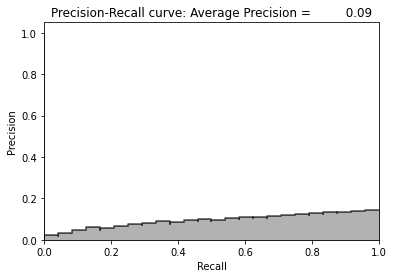

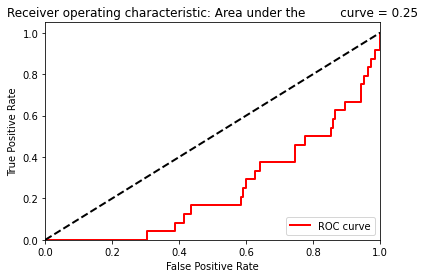

In [110]:
predictionsTrain = model.predict(X_train_original, verbose=1)
anomalyScoresAETrain = anomalyScores(X_train_original, predictionsTrain)
preds, average_precision = plotResults(y_train_original, \
                                      anomalyScoresAETrain, True)

### Evaluating the model on the test data

6/6 [==============================] - 0s 1ms/step


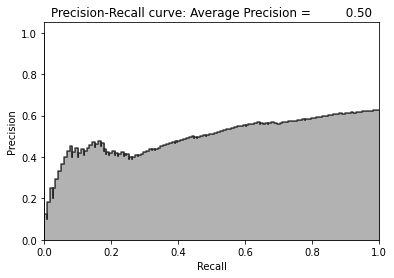

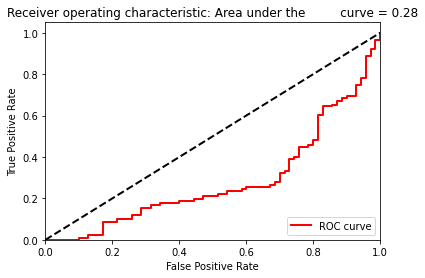

In [111]:
predictions = model.predict(X_test, verbose=1)
anomalyScoresAE = anomalyScores(X_test, predictions)
preds, average_precision = plotResults(y_test, anomalyScoresAE, True)

In [112]:
preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print("Precision at 75% recall", precision)

Precision at 75% recall 0.5769230769230769


## Semi-supervised Learning

In [113]:
layer_name = 'hidden_layer'

intermediate_layer_model = Model(inputs=model.input, \
                                 outputs=model.get_layer(layer_name).output)
intermediate_output_train = intermediate_layer_model.predict(X_train_original)
intermediate_output_test = intermediate_layer_model.predict(X_test_original)

In [114]:
intermediate_output_trainDF = \
    pd.DataFrame(data=intermediate_output_train,index=X_train_original.index)
intermediate_output_testDF = \
    pd.DataFrame(data=intermediate_output_test,index=X_test_original.index)

In [115]:
X_train = X_train_original.merge(intermediate_output_trainDF, \
                                 left_index=True,right_index=True)
X_test = X_test_original.merge(intermediate_output_testDF, \
                               left_index=True,right_index=True)
y_train = y_train_original.copy()

In [116]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index, \
                                        columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), \
                                          y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], \
        X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], \
        y_train.iloc[cv_index]
    
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train)
    gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=5000,
                   valid_sets=lgb_eval, early_stopping_rounds=200)
    
    loglossTraining = log_loss(y_train_fold, 
                                gbm.predict(X_train_fold, \
                                num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = \
        gbm.predict(X_cv_fold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(y_cv_fold, \
            predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossLightGBMGradientBoosting = log_loss(y_train, \
                        predictionsBasedOnKFolds.loc[:,'prediction'])
print('LightGBM Gradient Boosting Log Loss: ', \
                        loglossLightGBMGradientBoosting)

[1]	valid_0's binary_logloss: 0.412294
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's binary_logloss: 0.407177
[3]	valid_0's binary_logloss: 0.402247
[4]	valid_0's binary_logloss: 0.397492
[5]	valid_0's binary_logloss: 0.392902
[6]	valid_0's binary_logloss: 0.388466
[7]	valid_0's binary_logloss: 0.384176
[8]	valid_0's binary_logloss: 0.380124
[9]	valid_0's binary_logloss: 0.376067
[10]	valid_0's binary_logloss: 0.372222
[11]	valid_0's binary_logloss: 0.368378
[12]	valid_0's binary_logloss: 0.364727
[13]	valid_0's binary_logloss: 0.361078
[14]	valid_0's binary_logloss: 0.357601
[15]	valid_0's binary_logloss: 0.354132
[16]	valid_0's binary_logloss: 0.350821
[17]	valid_0's binary_logloss: 0.347518
[18]	valid_0's binary_logloss: 0.344356
[19]	valid_0's binary_logloss: 0.341208
[20]	valid_0's binary_logloss: 0.338185
[21]	valid_0's binary_logloss: 0.33524
[22]	valid_0's binary_logloss: 0.332294
[23]	valid_0's binary_logloss: 0.329472
[24]	valid_0's binary_loglo

### Plotting the precision recall and ROC curve

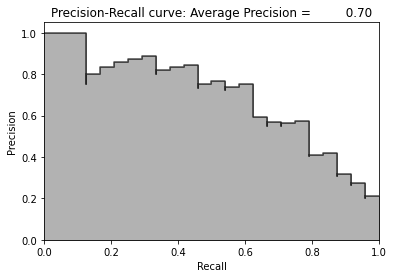

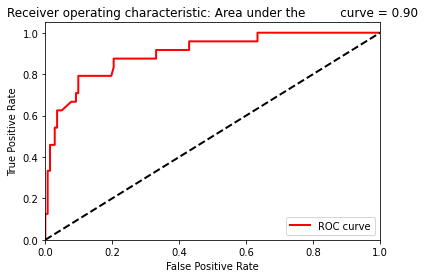

In [117]:
preds, average_precision = plotResults(y_train, \
                        predictionsBasedOnKFolds.loc[:,'prediction'], True)

### Evaluating the model on the test data

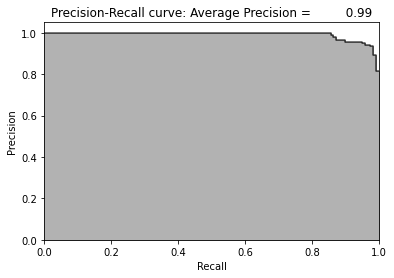

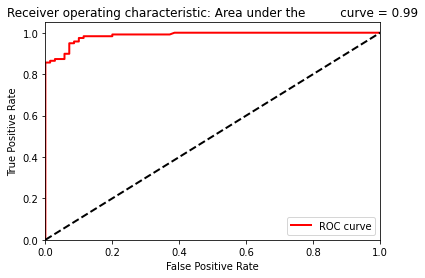

In [118]:
predictions = pd.Series(data=gbm.predict(X_test, \
                    num_iteration=gbm.best_iteration),index=X_test.index)
preds, average_precision = plotResults(y_test, predictions, True)

In [119]:
preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print(precision)

1.0


In [120]:
featuresImportance = pd.DataFrame(data=list(gbm.feature_importance()), \
                        index=X_train.columns,columns=['featImportance'])
featuresImportance = featuresImportance/featuresImportance.sum()
featuresImportance.sort_values(by='featImportance', \
                               ascending=False,inplace=True)
featuresImportance

,featImportance
29,0.142361
mean_perimeter,0.089583
23,0.081944
37,0.061806
12,0.061806
9,0.056944
6,0.050000
26,0.050000
4,0.045833
10,0.040278


Above table shows the importance of the features in our dataset.